# Projet 7 : Réalisez des indexations automatiques d’images
# <u>A. Traitements des images</u> <br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show
import seaborn as sns

import os
from scipy import io
import scipy.ndimage as spi
from glob import glob
import shutil
import time

import cv2

from PIL import Image, ImageOps, ImageFilter
from matplotlib.pyplot import imshow

%matplotlib inline

In [2]:
DATA_DIR = 'data'
LIST_DIR = DATA_DIR + '/lists'
IMAGE_DIR = DATA_DIR + '/Images'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'
ANNOTATION_DIR = DATA_DIR + '/Annotation'

# 1. Analyse exploratoire

Voyons la volumétrie de nos données

In [4]:
image_files = glob(IMAGE_DIR + '/*/*.jpg')
folders = [ name for name in os.listdir(IMAGE_DIR) if os.path.isdir(os.path.join(IMAGE_DIR, name)) ]

In [5]:
print("Total races (dossier) : ", len(folders))
print("Total images  : ",len(image_files))

Total races (dossier) :  120
Total images  :  20580


Avons nous des images de même taille ?

In [6]:
img_size = np.asarray([plt.imread(f).shape for f in image_files])

Text(0,0.5,'hauteur')

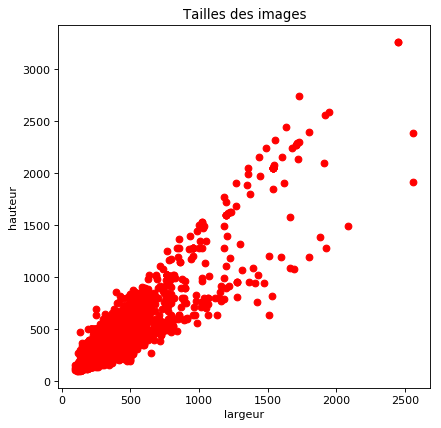

In [7]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(img_size[:,0], img_size[:,1], c = 'red')
plt.title("Tailles des images")
plt.xlabel("largeur")
plt.ylabel("hauteur")

Nombre d'images par race.

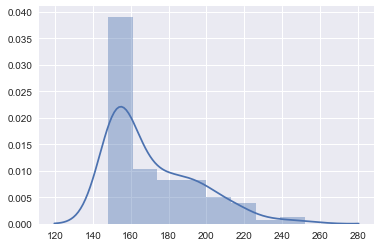

In [8]:
sns.set(color_codes=True)
images_per_feed = np.array([len(glob(IMAGE_DIR + "/" + f + '/*.jpg')) for f in folders])
sns.distplot(images_per_feed)

- Chaque dossier contient au minimum 150 images. 
- La grande majorité des dossiers ont 150 images.
- Le maximum d'images est de 280

# 2. Annotations

Lecture des fichiers annotations

In [69]:
from xml.dom import minidom
rows_list = []
for root, subdirs, files in os.walk(ANNOTATION_DIR):
    for filename in files:
        if (filename.startswith('n')) :
            file_path = os.path.join(root, filename)
            with open(file_path, 'rb') as f:
                annon_xml = minidom.parse(f)
                dog_info={}
                a_folder = annon_xml.getElementsByTagName('folder')[0].firstChild.nodeValue
                a_filename = annon_xml.getElementsByTagName('filename')[0].firstChild.nodeValue
                if (a_folder == '%s') :
                    a_folder = filename.split('_')[0][1:]
                dog_info['folder'] = a_folder
                if (a_filename == '%s') :
                    a_filename = filename   
                dog_info['filename'] = a_filename
                dog_info['breed'] = annon_xml.getElementsByTagName('name')[0].firstChild.nodeValue
                dog_info['xmin'] = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
                dog_info['ymin'] = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
                dog_info['xmax'] = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
                dog_info['ymax'] = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
                rows_list.append(dog_info)
annotations_df=pd.DataFrame(rows_list)
annotations_df = annotations_df[['folder', 'filename', 'breed', 'xmin', 'ymin', 'xmax', 'ymax']]

In [70]:
annotations_df.head()

,folder,filename,breed,xmin,ymin,xmax,ymax
0,02097658,n02097658_98,silky_terrier,93,117,269,289
1,02097658,n02097658_2535,silky_terrier,216,69,498,289
2,02097658,n02097658_271,silky_terrier,0,0,366,331
3,02097658,n02097658_427,silky_terrier,174,1,1018,762
4,02097658,n02097658_4890,silky_terrier,124,27,357,281


# 3.  Manipulation des images

In [55]:
def show_images(img1, cmap1, img2, cmap2) :
    f = plt.figure(figsize=(10,10))
    i1 = f.add_subplot(1,2, 1)
    i1.axis('off')
    imshow(img1, cmap = cmap1)
    i2 = f.add_subplot(1,2, 2)
    i2.axis('off')
    imshow(img2, cmap=cmap2)
    plt.show(block=True)

Largeur : 427 px, hauteur : 392 px channels: 3


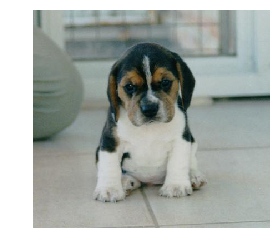

In [17]:
img_orig = cv2.imread(IMAGE_DIR + '/n02088364-beagle/n02088364_1507.jpg')
# Récupérer et afficher la taille de l'image (en pixels)
h, w, channel = img_orig.shape
print("Largeur : {} px, hauteur : {} px channels: {}".format(w, h, channel))
plt.axis('off')
imshow(cv2.cvtColor(img_orig, cv2.CV_32S))

### Gray Scale

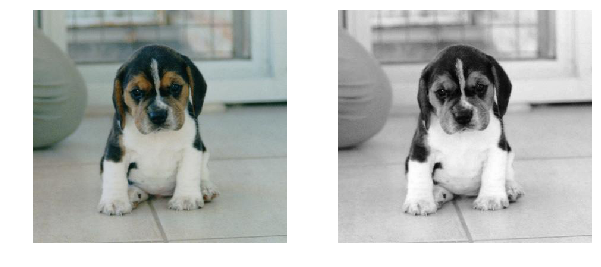

In [103]:
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, gray, 'gray')

### Equalize Histogram

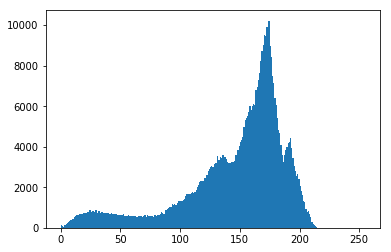

In [18]:
n, bins, patches = plt.hist(np.array(img_orig).flatten(), bins=range(256))
plt.show()

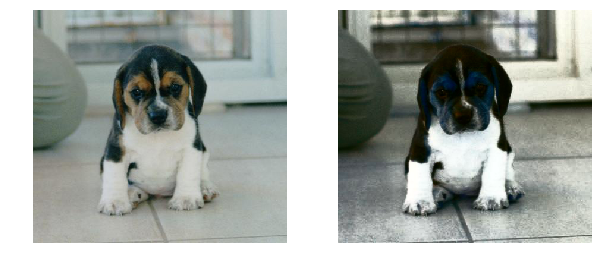

In [105]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_trans = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, img_trans, None)

### Cropping

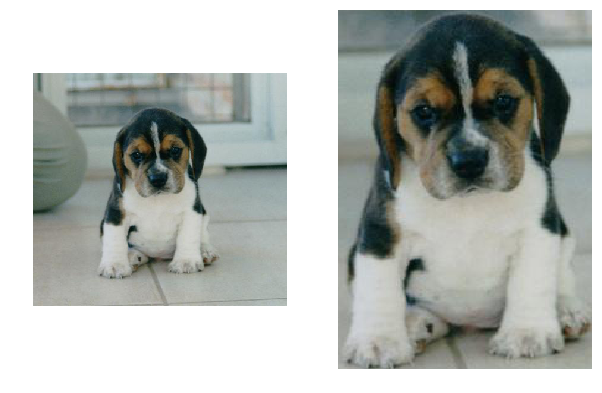

In [99]:
box = annotations_df[annotations_df['filename'] == 'n02088364_1507']
cropped_img = img[int(box.ymin):int(box.ymax), int(box.xmin):int(box.xmax)]
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(cropped_img, cv2.CV_32S), None)

### Gaussian Blur

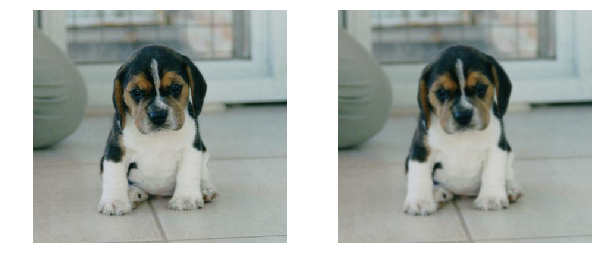

In [102]:
blur = cv2.GaussianBlur(img_orig,(5,5),0)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(blur, cv2.CV_32S), None)

# 4. Prétraitement des images

In [67]:
wsize, hsize = (50,50)

In [68]:
def retrieveBoxingArea(filename) :
    box = annotations_df[annotations_df['filename'] == filename]
    area = (int(box.xmin), int(box.ymin), int(box.xmax), int(box.ymax))
    return area

In [80]:
def preprocessImages(files_list, folder) :
    for f in files_list :
        # Load image
        img = Image.open(folder+ '/'+ f)
        
        # cropping
        filename = f.split("/")[1][:-4]
        img = img.crop(retrieveBoxingArea(filename))
        
        #resizing
        img = img.resize((wsize, hsize), Image.ANTIALIAS)
        
        # Equalization
        img = ImageOps.equalize(img)
        
        #greyscale
        img = ImageOps.grayscale(img)
        #imshow(img)
        img.save(folder + '/' + f)

# 5. Préparation des données entrainement et test

On sauvegarde le nom des dossiers qui se trouvent dans Images

In [70]:
image_paths = glob(IMAGE_DIR + '/*')
image_folders = [s[12:] for s in image_paths]

In [71]:
# Déplacement des images de la liste dans un nouveau dossier
def copy_image_files(image_list, new_folder):
    for file in image_list:
        if os.path.exists(IMAGE_DIR + '/' + file):
            shutil.copy(IMAGE_DIR + '/' + file, new_folder+'/'+file)
        else :
            print('%s does not exist, it may be missing' % (IMAGE_DIR + '/' + file))

In [72]:
def save_labels(image_list, dest_folder) :
    rows_list = []
    for file in image_list:
        file_info={}
        file_info['folder'] = file.split("/")[0]
        file_info['breed'] = file_info['folder'].split("-")[1]
        file_info['id'] = file.split("/")[1][:-4]
        rows_list.append(file_info)
    labels=pd.DataFrame(rows_list)
    labels = labels[['id', 'breed', 'folder']]
    labels.to_csv(dest_folder + '/labels.csv')

On se base sur le fichier train_list et test_list pour configurer nos jeux d'entrainement et de test.

In [84]:
#n02089973-English_foxhound/n02089973_3651.jpg
#retrieveBoxingArea('n02085620_1502')
preprocessImages(['n02085620-Chihuahua/n02085620_5927.jpg'], TRAIN_DIR)

In [73]:
if not os.path.exists(TRAIN_DIR):
    train_list = io.loadmat(LIST_DIR +'/train_list.mat')['file_list']
    train_list = np.array([t[0] for t in train_list[:,0]])
    for folder in image_folders:
        os.makedirs(TRAIN_DIR + '/' + folder)
    copy_image_files(train_list, TRAIN_DIR)
    save_labels(train_list,TRAIN_DIR)
    preprocessImages(train_list, TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    test_list  = io.loadmat(LIST_DIR + '/test_list.mat')['file_list']
    test_list = np.array([t[0] for t in test_list[:,0]])
    for folder in image_folders:
        os.makedirs(TEST_DIR + '/' + folder)
    copy_image_files(test_list, TEST_DIR)
    save_labels(test_list,TEST_DIR)